# Airline Customer Segmentation | Data Modeling | Fredrick Runie Taslim

In [ ]:
from factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid

In [ ]:
df = pd.read_csv('airplane_satisfaction_eda.csv')
df.shape

(129880, 26)

In [ ]:
df.head(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Binned Age
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,4,3,4,4,5,5,25,18,neutral or dissatisfied,1
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,5,3,1,4,1,1,6,neutral or dissatisfied,2
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,4,3,4,4,4,5,0,0,satisfied,2
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,5,3,1,4,2,11,9,neutral or dissatisfied,2
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,4,4,3,3,3,0,0,satisfied,1


## 1. Evaluate Dataset

### a) Bartlett's Test of Sphericity

**Bartlett's Test of Sphericity** serves as a tool for researchers to assess the appropriateness of using factor analysis to delve into the underlying structure of their data, primarily by scrutinizing the correlation or covariance among variables. If the test reveal interdependencies among variables, it suggests a potential pathway to employ factor analysis in uncovering latent factors.

To start, I filtered the dataset by retaining solely those columns containing numerical values assessed using a **Likert scale**.

In [ ]:
subset_data = df.iloc[:, 8:22]
subset_data.shape

(129880, 14)

In [ ]:
chi_square_statistic, p_value = calculate_bartlett_sphericity(subset_data)

print("Chi-Square Statistic: ", chi_square_statistic) # Chi-Square Statistic:  601676.8938564158
print("P-value: ", p_value) # P-value:  0.0

Chi-Square Statistic:  753739.3136623382
P-value:  0.0


**Interpretation**
<br/>The P-value is lower than 0.05, which means that this dataset is suitable for the Factor Analysis!

### b) KMO-test

The **Kaiser-Meyer-Olkin (KMO)** statistic serves as a tool in statistical analysis to evaluate the suitability of a dataset for factor analysis. Its primary function lies in assessing the extent of shared variance among variables, thereby indicating whether the dataset is conducive to factor analysis. Essentially, the KMO measure quantifies the proportion of variance among variables that is jointly accounted for, a crucial determinant for conducting factor analysis.

In [ ]:
kmo_all, kmo_model = calculate_kmo(subset_data)

print("KMO for All Variables:", kmo_all)
'''
KMO for All Variables: [0.74185992 0.75273127 0.68173114 0.7066898  0.84090996 0.73646005
 0.8328631  0.76790363 0.82883039 0.88966489 0.8147844  0.70010319 0.78427772 0.81687404]
'''
print("KMO for Model:", kmo_model) # KMO for Model: 0.7812327154821392

KMO for All Variables: [0.74296742 0.75314321 0.68318738 0.70642046 0.84098387 0.73577134
 0.83163793 0.76793975 0.82921948 0.88932116 0.81528592 0.69906246
 0.78470331 0.81805094]
KMO for Model: 0.7815228729684615


| KMO measure | Interpretation |
|---|---|
| KMO ≥ 0.90 | Marvelous |
| 0.80 ≤ KMO < 0.90 | Meritorious |
| 0.70 ≤ KMO < 0.80 | Average |
| 0.60 ≤ KM0 < 0.70 | Mediocre |
| 0.50 ≤ KMO < 0.60 | Terrible |
| KM0 < 0.50 | Unacceptable |

**Interpretation**
</br>The mean Kaiser-Meyer-Olkin (KMO) statistic for the variables surpasses 0.6, with each variable independently exhibiting a KMO value exceeding 0.6 as well. Based on these results, I inferred from these findings that the dataset is well-suited for Factor Analysis.

## 2. Determine the number of factors - PCA

Prior to conducting Factor Analysis (FA), **Principal Component Analysis (PCA)** is employed to ascertain the appropriate number of factors.
<br/>This sequential process ensures that the factors identified in FA encapsulate the essential variability present within the dataset.

In [ ]:
# Standardization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(subset_data)

In [ ]:
# PCA
pca = PCA()
pca.fit(data_scaled)

PCA()

In [ ]:
# Check Eigen Score
eigen_values = pca.explained_variance_
variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_ratio = variance_ratio.cumsum()

In [ ]:
# To DataFrame
pca_results = pd.DataFrame({
    'eigenvalue': eigen_values,
    'percentage of variance': variance_ratio,
    'cumulative percentage of variance': cumulative_ratio
})
pca_results.index = ['comp ' + str(i+1) for i in pca_results.index]

In [ ]:
pca_results

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,3.797210,27.122716,27.122716
comp 2,2.371380,16.938295,44.061011
comp 3,2.169016,15.492849,59.553860
comp 4,1.062907,7.592133,67.145993
comp 5,0.949852,6.784607,73.930601
comp 6,0.698096,4.986358,78.916959
comp 7,0.537129,3.836606,82.753565
comp 8,0.513837,3.670237,86.423802
comp 9,0.468204,3.344285,89.768087
comp 10,0.367962,2.628277,92.396364


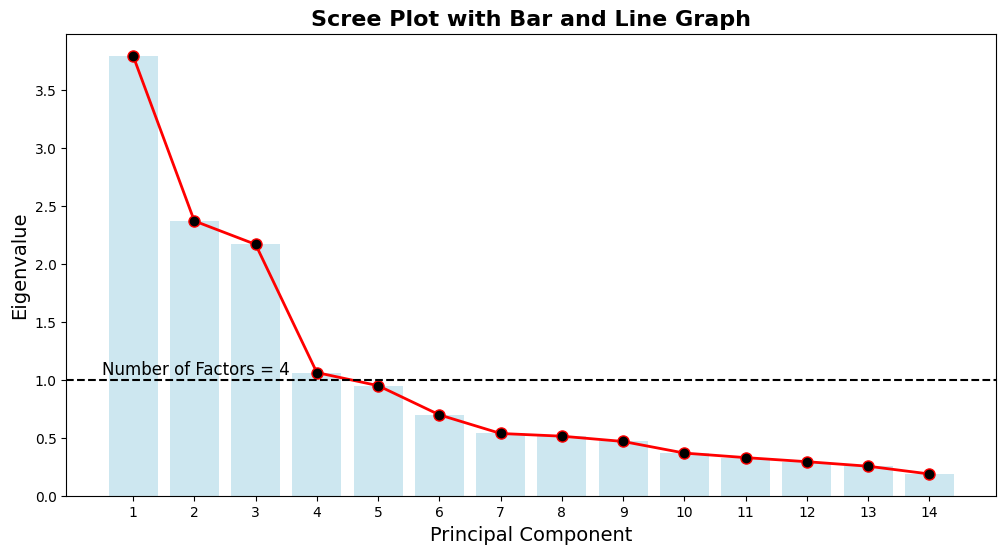

In [ ]:
# Visualize the result
plt.figure(figsize=(12,6))
plt.bar(range(1, len(eigen_values) + 1), eigen_values, alpha=0.6, color='lightblue')
plt.plot(range(1, len(eigen_values) + 1), eigen_values, 'o-', linewidth=2, color='red', markerfacecolor='black', markersize=8)
plt.title('Scree Plot with Bar and Line Graph', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.axhline(y=1, color='black', linestyle='--')
plt.xticks(range(1, len(eigen_values) + 1))
plt.yticks(np.arange(0, max(eigen_values), step=0.5))

n_factors = np.sum(eigen_values >= 1)
plt.text(0.5, 1.05, f'Number of Factors = {n_factors}', color = 'black', fontsize=12)

plt.show()

We selected 4 factors with higher-than-1.0-eigen value.

## 3. Extract the Factor Solution - Factor Analysis

Following the determination of significant factors via PCA, we proceeded to employ **Factor Analysis (FA)** on the raw data (cleaned_dataset) in order to comprehend the inherent connections within the data.

In [ ]:
fa = FactorAnalyzer(n_factors=4, rotation='varimax')
fa.fit(data_scaled)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [ ]:
loadings_df = pd.DataFrame(fa.loadings_, index=subset_data.columns, columns=[f'Factor{i+1}' for i in range(4)])
loadings_df

,Factor1,Factor2,Factor3,Factor4
Inflight wifi service,0.092560,0.131545,0.609605,0.472656
Departure/Arrival time convenient,-0.009877,0.055483,0.589610,-0.000282
Ease of Online booking,-0.035278,0.028295,0.768323,0.456030
Gate location,0.013059,-0.046538,0.683671,-0.104661
Food and drink,0.770685,0.002546,0.030307,0.039919
Online boarding,0.285147,0.117670,0.100954,0.757681
Seat comfort,0.755170,0.077046,-0.028192,0.214319
Inflight entertainment,0.768362,0.464174,0.041047,0.030834
On-board service,0.086289,0.701394,0.010312,0.051642
Leg room service,0.057996,0.484668,0.042495,0.095939


## 4. Create and Name the Factors

In determining the names for each factor, we considered the top three components with the highest loading scores.

The first factor was labeled “Inflight Comfort & Quality” due to its association with aspects contributing to a pleasant in-flight experience:
1. Cleanliness (0.84)
2. Food and drink (0.77)
3. Inflight entertainment (0.77)

The second factor was designated as “Customer Service Quality” because its primary components reflect the quality of service received throughout the journey:
1. Inflight service (0.80)
2. Baggage handling (0.76)
3. On-board service (0.70)

For the third factor, we opted for the name “Convenience and Efficiency” since its highest loading components focus on enhancing time efficiency during travel:
1. Ease of online booking (0.77)
2. Gate location (0.68)
3. Inflight wifi service (0.61)

Lastly, we named the fourth factor “Technological Accessibility” as its components highlight the ease of technological access during the flight experience:
1. Online boarding (0.76)
2. Inflight wifi service (0.47)
3. Ease of online booking (0.46)

In [ ]:
scores = fa.transform(subset_data)
subset_data['Inflight Comfort and Quality'] = scores[:, 0]
subset_data['Customer Service Quality'] = scores[:, 1]
subset_data['Convenience and Efficiency'] = scores[:, 2]
subset_data['Technological Accessibility'] = scores[:, 3]

In [ ]:
subset_data.shape # (103904, 18)

(129880, 18)

In [ ]:
print(subset_data.columns.to_list())

['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Inflight Comfort and Quality', 'Customer Service Quality', 'Convenience and Efficiency', 'Technological Accessibility']


## 5. Clustering - K-Means

### a) Determine the number of clusters

Determine number of clusters using silhouette score method

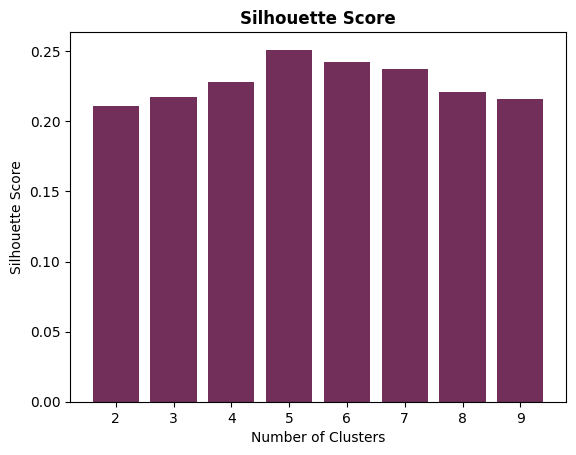

Best parameter grid: {'n_clusters': 5}
Best silhouette score: 0.25106109729096693


In [ ]:
data = subset_data.iloc[:, 14:]

# Define the range of parameters for the number of clusters
parameters = range(2, 10)  # Adjust the range as needed

# Instantiating ParameterGrid
parameter_grid = ParameterGrid({'n_clusters': parameters})

best_score = -1
best_grid = None
silhouette_scores = []

for p in parameter_grid:
    kmeans_model = KMeans(n_clusters=p['n_clusters'])
    kmeans_model.fit(data)
    ss = silhouette_score(data, kmeans_model.labels_)
    silhouette_scores.append(ss)

    if ss > best_score:
        best_score = ss
        best_grid = p

# Plotting silhouette score
plt.bar(parameters, silhouette_scores, color='#722f59')
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

print("Best parameter grid:", best_grid)
print("Best silhouette score:", best_score)


### b) K-Means

In [ ]:
df_clustering = subset_data.iloc[:, 14:]
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_clustering)
df_clustering["Cluster"] = kmeans.labels_

In [ ]:
df_clustering["Cluster"].value_counts()

Cluster
2    38708
1    27726
4    23705
0    20417
3    19324
Name: count, dtype: int64

In [ ]:
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=df_clustering.columns[:-1])
centers_df

,Inflight Comfort and Quality,Customer Service Quality,Convenience and Efficiency,Technological Accessibility
0,3.501878,4.290958,1.182888,2.039477
1,1.053727,3.644314,2.803054,1.220713
2,3.443947,4.187656,3.848735,2.078978
3,3.590784,3.630042,2.288362,-0.243681
4,2.909166,2.030889,2.704624,1.981269


**Clusters Identification**:
1. **In-flight Experience Prioritized**: This segment achieved notable scores in "Inflight Comfort and Quality" and "Customer Service Quality," suggesting that these individuals prioritize comfort and quality during their flights, along with the service provided by the cabin crew. They are passengers who value their in-flight experience the most and expressing high satisfaction with factors like seating comfort, onboard meals, and entertainment options.

2. **Boarding Efficiency Focused**: This segment exhibited a higher preference for "Customer Service Quality" and "Convenience and Efficiency", indicating a higher value placed on the efficiency and convenience of the boarding process compared to the in-flight experience. This preference suggests that these customers prioritize aspects such as streamlined check-in procedures, swift security checks, and a seamless boarding process, emphasizing their focus on the pre-boarding phase.

3. **Quality-Driven**: This segment consistently achieved high ratings across all areas, especially standing out in "Customer Service Quality." This indicates that these customers prioritize top-notch service quality, expecting excellence not just in airline customer service but also in convenience and access to technology. They can be seen as individuals who value superior quality in every aspect of their air travel experience.

4. **Comfort and Efficiency Balancers** : This segment values "Inflight Comfort and Quality" and "Convenience and Efficiency," displaying moderate consideration for Customer Service Quality. However, their attention towards Technological Accessibility seems relatively lower. This could imply that they may not prioritize features such as  Wi-Fi availability, online boarding, or online booking offered by the airline. They may be less concerned about accessing technology-related amenities during their journey, possibly preferring traditional forms of entertainment or relaxation while flying.

5. **Budget-Conscious Travelers**: This segment has low scores across all categories. They may prioritize affordability over other aspects. This aligns with the previous EDA findings that say passengers who flew in Economy and Economy Plus Class tend to have lower satisfaction scores.

In [ ]:
result_df = centers_df
result_df["Customer Group"] = ['In-flight Experience Prioritized', 'Boarding Efficiency Focused', 'Quality-Driven', 'Comfort and Efficiency Balancers', 'Budget-Conscious Travelers']
result_df

,Inflight Comfort and Quality,Customer Service Quality,Convenience and Efficiency,Technological Accessibility,Customer Group
0,3.501878,4.290958,1.182888,2.039477,In-flight Experience Prioritized
1,1.053727,3.644314,2.803054,1.220713,Boarding Efficiency Focused
2,3.443947,4.187656,3.848735,2.078978,Quality-Driven
3,3.590784,3.630042,2.288362,-0.243681,Comfort and Efficiency Balancers
4,2.909166,2.030889,2.704624,1.981269,Budget-Conscious Travelers


In [ ]:
dbs = davies_bouldin_score(subset_data.iloc[:, 14:], kmeans.labels_)
print(f'Davies Bouldin Score: {dbs}')

Davies Bouldin Score: 1.2014142615180738



The Davies-Bouldin Index serves as a tool for assessing clustering algorithms, aiming to gauge the quality of a clustering solution. It functions by evaluating both intra-cluster similarity and inter-cluster dissimilarity, essential aspects for effective clustering. The lower the Davies-Bouldin score, the better the clustering.

- Intra-cluster similarity: This denotes the degree of similarity among data points within each cluster. Lower intra-cluster similarity implies greater coherence within clusters, a desirable trait for clustering efficacy
- Inter-cluster dissimilarity: This measures the dissimilarity between clusters. Reduced inter-cluster dissimilarity signifies more distinct separation between clusters, which is also desirable.

The Davies-Bouldin Index synthesizes these elements by computing the average similarity between each cluster and its most akin cluster, normalized by the average dissimilarity across all cluster pairs. A lower index score indicates better separation and denser clustering.

With a Davies-Bouldin Score of around 1.20, it suggests a relatively favorable clustering solution. This score implies that the clusters are well-separated and exhibit internal coherence and density.

Although the final score obtained through the silhouette score isn't the best, it is tolerable since the score obtained through the Davies-Bouldin index shows a favorable clustering solution.